## Visualizing  Spacy + Georesolver  - Total

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['Place']))
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['Place'], rotation=80, fontsize=7)

    if plot_type == "resolved":
        plt.bar(index, df_group_places['count'], color='green')
        plt.title('15 Places most mentioned using SpaCy and the Georesolver across all Scottitsh Gazetteer')
    else:
        plt.bar(index, df_group_places['count'], color='yellowgreen')
        plt.title('15 Places most mentioned but not resolved using SpaCy and the Georesolver across all Scottitsh Gazetteer')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [7]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [8]:
df_total= geresolution_dataframe(results)

year 1803
year 1806
year 1846
year 1828
year 1842
year 1838
year 1882
year 1868
year 1825
year 1901
year 1848
year 1883


In [9]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,39.9153695,-77.5366551,Lakes,Page9,1803
1,55.95,-3.3725,EDINBURGH,Page9,1803
2,42.2630415,-92.69269869999999,Counties,Page9,1803
3,51.64875,-0.0974,LONDON,Page9,1803
4,41.5581,-90.5198,Cities,Page9,1803


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    170549
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [11]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

**Important: Number of Places that has been identified but not resolved!**

In [12]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     0
Longitude    0
Place        0
Page         0
Year         0
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [13]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     170549
Longitude    170549
Place        170549
Page         170549
Year         170549
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [14]:
df_resolved = df_total[df_total['Latitude'] != '']

In [15]:
df_resolved.count()

Latitude     170549
Longitude    170549
Place        170549
Page         170549
Year         170549
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [16]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [17]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying just the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,39.9153695,-77.5366551,Lakes,Page9,1803
1,55.95,-3.3725,Edinburgh,Page9,1803
2,42.2630415,-92.69269869999999,Counties,Page9,1803
3,51.64875,-0.0974,London,Page9,1803
4,41.5581,-90.5198,Cities,Page9,1803
5,56.39153,-3.43951,Scotland,Page9,1803
6,55.8666667,-4.25,Glasgow,Page9,1803
7,56.4,-3.4333333,Perth,Page9,1803
8,57.1333333,-2.1,Aberdeen,Page9,1803
9,60.293386,5.218142,Bergen,Page11,1803


In [19]:
df_max_geolocations = df_capitalized[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_max_geolocations.count())
#displaying just the first 15 rows
df_max_geolocations.head(15)


Latitude     12503
Longitude    12503
count        12503
dtype: int64


,Latitude,Longitude,count
9440,55.8666667,-4.25,3219
9674,55.95,-3.3725,2870
10444,56.5,-4,2801
9798,56,-4,2447
11035,57.1666667,-2.6666667,1819
9437,55.8666667,-3.9166667,1635
10302,56.39153,-3.43951,1579
11085,57.20194,-2.19778,1526
10131,56.25,-3.1666667,1476
178,-23.5166667,27.8333333,1448


In [23]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=[]
place_label, place_freq = label_freq_places(df_capitalized, df_max_geolocations, filter_list)

0 3219 Glasgow
1 2870 Edinburgh
2 2801 Perthshire
3 2447 Scotland
4 1819 Aberdeenshire
5 1635 Lanarkshire
6 1579 Scotland
7 1526 Aberdeen
8 1476 Fife
9 1448 Forfarshire
10 1438 Glasgow
11 1407 Inverness
12 1223 Edinburgh
13 1208 Stirling
14 1177 Edinburgh
15 1144 Ayr
16 1128 Perth
17 1073 Glasgow
18 1010 Dundee
19 965 Argyllshire


In [24]:
#Visualizing the 15 places in a Bar plot
df_places = {'Place':place_label,'Place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_group_places

,Place,count
8,Glasgow,5730
5,Edinburgh,5270
13,Scotland,4026
12,Perthshire,2801
1,Aberdeenshire,1819
10,Lanarkshire,1635
0,Aberdeen,1526
6,Fife,1476
7,Forfarshire,1448
9,Inverness,1407


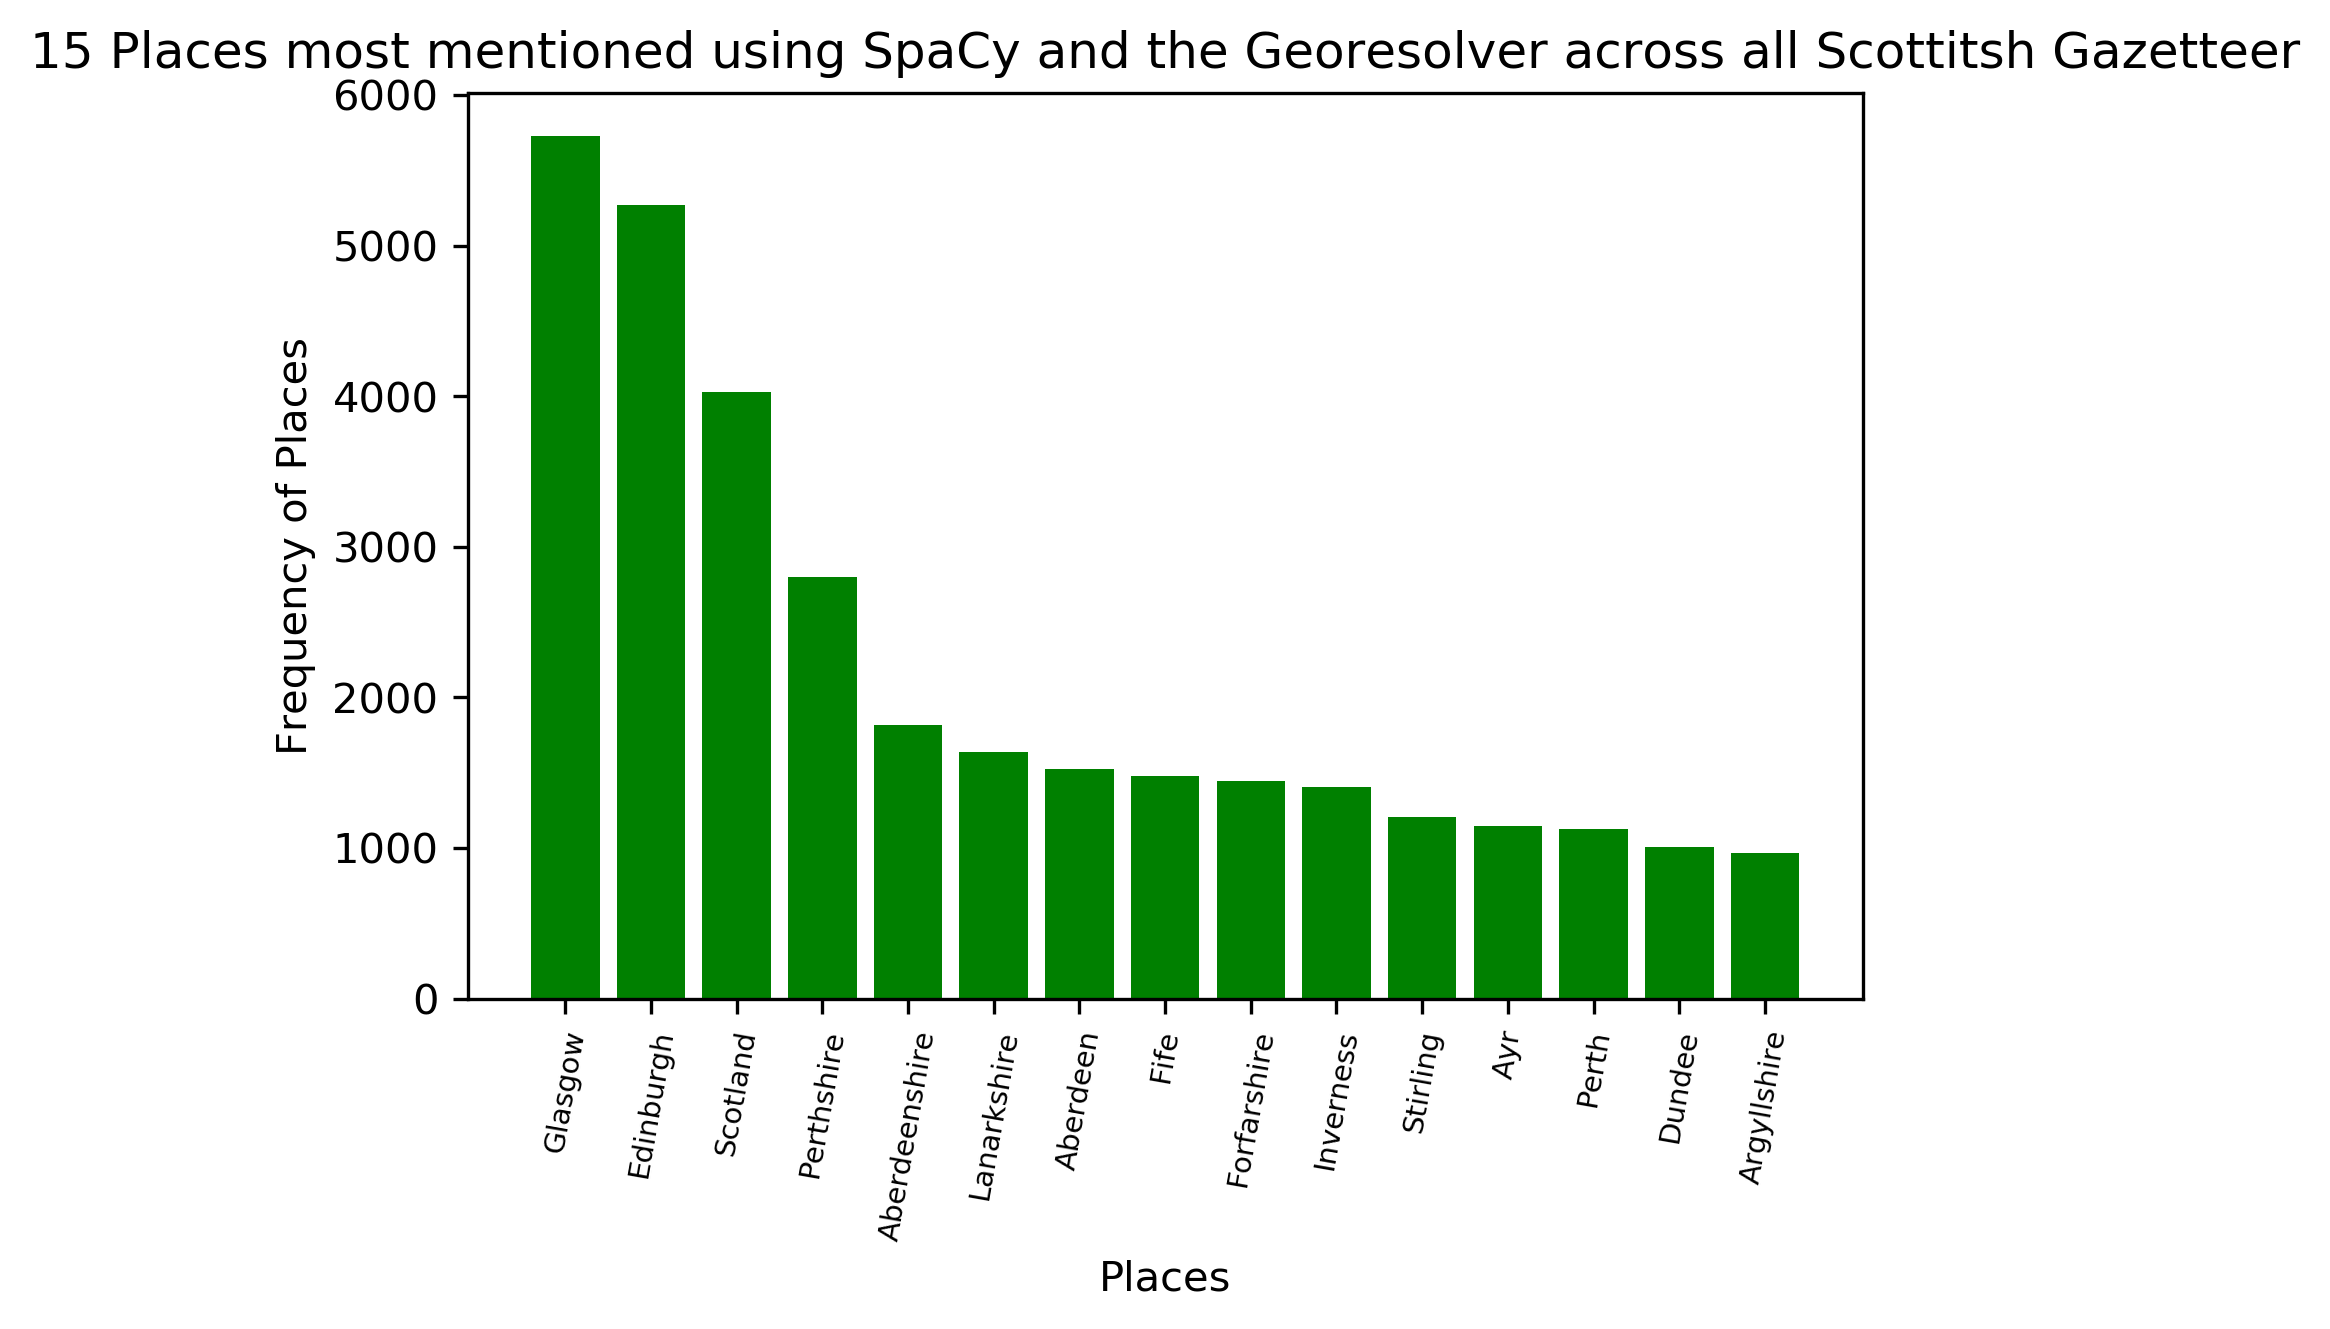

In [25]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places, plot_type='resolved')